# 🕵️ Text-to-SQL Agent: Chat with Your Database

**Scenario:** You are the Lead Data Architect for a growing e-commerce company. Your business teams (Sales, Marketing, Logistics) need answers *fast*. "How many orders did we ship to Sao Paulo last month?" "What are our top 5 product categories?"

**The Problem:** The data is locked in a SQL database. Your business users don't know SQL. They constantly ping the data team for simple reports, creating a bottleneck.

**The Solution:** An **Agentic Text-to-SQL System**! We will build an AI agent that can:
1.  Understand natural language questions.
2.  **Write valid SQL** queries against your specific schema.
3.  **Self-Correct** if the SQL fails (Agentic Loop).
4.  **Execute** the query safely.
5.  **Visualize** the results with charts.

**What You'll Build:** A robust Multi-Agent workflow using **LangGraph** and **LiteLLM** that orchestrates specialized workers (SQL Expert, Data Analyst, Visualization Specialist) to turn questions into insights.

---

## 📦 Setup

We need `langgraph` for orchestration, `litellm` for model abstraction (Gemini, OpenAI, Claude), and `pandas`/`plotly` for data handling.

In [14]:
# Install dependencies (if not already installed)
%pip install -q langgraph litellm pandas plotly python-dotenv


/Users/param/learn/learnwithparam/lwp-workshops/text-to-sql-agentic-rag-chatbot/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import sqlite3
import json
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from typing import TypedDict, List, Dict, Any
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from litellm import completion

# Load environment variables (.env)
load_dotenv()

# Configuration
DB_PATH = "ecommerce.db"
DEFAULT_MODEL = os.getenv("DEFAULT_MODEL", "gpt-4o-mini")

print(f"✅ System initialized using model: {DEFAULT_MODEL}")

import litellm
import logging

# Suppress noisy debug logs
litellm.suppress_debug_info = True
logging.getLogger("litellm").setLevel(logging.CRITICAL)

✅ System initialized using model: openrouter/google/gemini-2.0-flash-001


## 🗃️ The Knowledge Base: Database Schema

For an LLM to write good SQL, it needs to understand the database structure (Tables, Columns, Relationships). We provide this as a context string.

In [16]:
SCHEMA_INFO = """
Database Schema for E-commerce System:

1. customers
   - customer_id (TEXT): Unique customer identifier
   - customer_unique_id (TEXT): Unique customer identifier across datasets
   - customer_zip_code_prefix (INTEGER): Customer zip code
   - customer_city (TEXT): Customer city
   - customer_state (TEXT): Customer state

2. orders
   - order_id (TEXT): Unique order identifier
   - customer_id (TEXT): Foreign key to customers
   - order_status (TEXT): Order status (delivered, shipped, etc.)
   - order_purchase_timestamp (TEXT): When the order was placed
   - order_approved_at (TEXT): When payment was approved
   - order_delivered_carrier_date (TEXT): When order was handed to carrier
   - order_delivered_customer_date (TEXT): When customer received the order
   - order_estimated_delivery_date (TEXT): Estimated delivery date

3. order_items
   - order_id (TEXT): Foreign key to orders
   - order_item_id (INTEGER): Item sequence number within order
   - product_id (TEXT): Foreign key to products
   - seller_id (TEXT): Foreign key to sellers
   - shipping_limit_date (TEXT): Shipping deadline
   - price (REAL): Item price
   - freight_value (REAL): Shipping cost

4. order_payments
   - order_id (TEXT): Foreign key to orders
   - payment_sequential (INTEGER): Payment sequence number
   - payment_type (TEXT): Payment method (credit_card, boleto, etc.)
   - payment_installments (INTEGER): Number of installments
   - payment_value (REAL): Payment amount

5. order_reviews
   - review_id (TEXT): Unique review identifier
   - order_id (TEXT): Foreign key to orders
   - review_score (INTEGER): Review score (1-5)
   - review_comment_title (TEXT): Review title
   - review_comment_message (TEXT): Review message
   - review_creation_date (TEXT): When review was created
   - review_answer_timestamp (TEXT): When review was answered

6. products
   - product_id (TEXT): Unique product identifier
   - product_category_name (TEXT): Product category (in Portuguese)
   - product_name_lenght (REAL): Product name length
   - product_description_lenght (REAL): Product description length
   - product_photos_qty (REAL): Number of product photos
   - product_weight_g (REAL): Product weight in grams
   - product_length_cm (REAL): Product length in cm
   - product_height_cm (REAL): Product height in cm
   - product_width_cm (REAL): Product width in cm

7. sellers
   - seller_id (TEXT): Unique seller identifier
   - seller_zip_code_prefix (INTEGER): Seller zip code
   - seller_city (TEXT): Seller city
   - seller_state (TEXT): Seller state

8. geolocation
   - geolocation_zip_code_prefix (INTEGER): Zip code prefix
   - geolocation_lat (REAL): Latitude
   - geolocation_lng (REAL): Longitude
   - geolocation_city (TEXT): City name
   - geolocation_state (TEXT): State code

9. product_category_name_translation
   - product_category_name (TEXT): Category name in Portuguese
   - product_category_name_english (TEXT): Category name in English
"""


## 🧠 Architecture: The State & The Agents

In LangGraph, the **State** is the shared memory that passes between agents. Our agents read from and write to this state.

In [17]:
class AgentState(TypedDict):
    """Shared state between all agents in the workflow"""
    question: str                # The user's original question
    sql_query: str               # The generated SQL
    query_result: str            # The result from the database (JSON string)
    final_answer: str            # The natural language response
    error: str                   # Any error messages
    iteration: int               # Counter for retries
    needs_graph: bool           # Flag: true if visualization is needed
    graph_type: str             # 'bar', 'line', 'pie', etc.
    graph_json: str             # Plotly JSON for rendering
    is_in_scope: bool           # Flag: true if question is relevant
    guardrails_reason: str      # Why it is/isn't in scope
    sql_reason: str             # Explanation for the generated SQL
    graph_reason: str           # Why a graph was chosen

### Agent Personas

We define specialized prompts for each role. This 'Prompt Engineering' is critical for getting reliable outputs.

In [18]:
AGENT_CONFIGS = {
    "guardrails_agent": {
        "role": "Security and Scope Manager",
        "system_prompt": "You are a strict guardrails system that filters questions to ensure they are relevant to e-commerce data analysis or identifies greetings.",
    },
    "sql_agent": {
        "role": "SQL Expert", 
        "system_prompt": "You are a senior SQL developer specializing in e-commerce databases. Generate only valid SQLite queries without any formatting or explanation.",
    },
    "analysis_agent": {
        "role": "Data Analyst",
        "system_prompt": "You are a helpful data analyst that explains database query results in natural language with clear insights.",
    },
    "viz_agent": {
        "role": "Visualization Specialist", 
        "system_prompt": "You are a data visualization expert. Generate clean, executable Plotly code without any markdown formatting or explanations.",
    },
    "error_agent": {
        "role": "Error Recovery Specialist",
        "system_prompt": "You diagnose and fix SQL errors with expert knowledge of database schemas and query optimization.",
    }
}

## 🛠️ Step 1: The Guardrails Agent

This agent protects our system from irrelevant queries ("What is the meaning of life?") and handles greetings politely.

In [19]:
def guardrails_agent(state: AgentState) -> AgentState:
    """Check if the question is within scope (e-commerce related)"""
    question = state["question"]
    print(f"--- 🛡️ Guardrails Checking: '{question}' ---")
    
    prompt = f"""You are a guardrails system. Determine if a user's question is related to e-commerce data (customers, orders, products, sellers, payments, reviews) or if it's a greeting.

User Question: {question}

Respond in JSON format:
{{
    "is_in_scope": true/false,
    "is_greeting": true/false,
    "reason": "brief explanation"
}}
"""

    response = completion(
        model=DEFAULT_MODEL,
        messages=[
            {"role": "system", "content": AGENT_CONFIGS["guardrails_agent"]["system_prompt"]},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        response_format={"type": "json_object"}
    )
    
    result = json.loads(response.choices[0].message.content)
    state["is_in_scope"] = result.get("is_in_scope", False)
    state["guardrails_reason"] = result.get("reason", "")
    
    if result.get("is_greeting", False):
        state["final_answer"] = "Hi! I'm your E-commerce Data Assistant. Ask me about orders, customers, or products!"
        state["is_in_scope"] = False # Stop further processing for greetings
    
    elif not state["is_in_scope"]:
        state["final_answer"] = "I can only answer questions about the e-commerce database (orders, customers, products, etc.)."
    
    return state

## 🛠️ Step 2: The SQL Agent

The core brain. It takes the natural language and the schema to produce executable SQL.

In [20]:
def sql_agent(state: AgentState) -> AgentState:
    """Generate SQL query from natural language question"""
    question = state["question"]
    print(f"--- 🤖 Generating SQL ---")
    
    prompt = f"""You are a SQL expert. Convert this question into a SQLite query.

{SCHEMA_INFO}

Question: {question}

Guidelines:
1. Use only provided tables/columns.
2. Return JSON with 'sql_query' and 'reasoning'.
3. Use ISO dates (TEXT).
4. LIMIT to 10 rows by default unless specified.
"""

    response = completion(
        model=DEFAULT_MODEL,
        messages=[
            {"role": "system", "content": AGENT_CONFIGS["sql_agent"]["system_prompt"]},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        response_format={"type": "json_object"}
    )
    
    result = json.loads(response.choices[0].message.content)
    state["sql_query"] = result.get("sql_query", "").replace("```sql", "").replace("```", "").strip()
    state["sql_reason"] = result.get("reasoning", "")
    state["iteration"] = state.get("iteration", 0) + 1
    
    return state

## 🛠️ Step 3: Tool Execution & Error Recovery

We need a function to actually run the SQL. We also define the `error_agent` which is called if execution fails.

In [21]:
def execute_sql(state: AgentState) -> AgentState:
    """Execute the generated SQL query"""
    sql_query = state["sql_query"]
    print(f"--- ⚡ Executing SQL: {sql_query} ---")
    
    try:
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()
        
        # Handle multiple statements
        statements = [s.strip() for s in sql_query.split(';') if s.strip()]
        results = []
        
        for stmt in statements:
            cursor.execute(stmt)
            rows = cursor.fetchall()
            if rows:
                cols = [desc[0] for desc in cursor.description]
                results = [dict(zip(cols, row)) for row in rows[:50]] # Limit results
        
        conn.close()
        
        if not results:
            state["query_result"] = "No results found."
        else:
            state["query_result"] = json.dumps(results, indent=2)
            
        state["error"] = ""
        
    except Exception as e:
        state["error"] = f"SQL Execution Error: {str(e)}"
        state["query_result"] = ""
        print(f"❌ Error: {state['error']}")
    
    return state

def error_agent(state: AgentState) -> AgentState:
    """Fix SQL if execution failed"""
    print("--- 🔧 Fixing SQL Error ---")
    
    prompt = f"""The SQL query failed. Fix it.
{SCHEMA_INFO}
Question: {state['question']}
Failed Query: {state['sql_query']}
Error: {state['error']}

Return ONLY the corrected SQL query string.
"""
    
    response = completion(
        model=DEFAULT_MODEL,
        messages=[
            {"role": "system", "content": AGENT_CONFIGS["error_agent"]["system_prompt"]},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    
    fixed_query = response.choices[0].message.content.strip().replace("```sql", "").replace("```", "")
    state["sql_query"] = fixed_query
    state["error"] = ""
    state["iteration"] += 1
    
    return state

## 🛠️ Step 4: Analysis & Visualization

Once we have data, we need to understand it (`analysis_agent`) and visualize it (`viz_agent`).

In [22]:
def analysis_agent(state: AgentState) -> AgentState:
    """Explain results in natural language"""
    print("--- 🗣️ Analyzing Results ---")
    
    prompt = f"""Explain these database results in a clear, user-friendly way.
Question: {state['question']}
Results: {state['query_result']}
"""
    
    response = completion(
        model=DEFAULT_MODEL,
        messages=[
            {"role": "system", "content": AGENT_CONFIGS["analysis_agent"]["system_prompt"]},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7
    )
    
    state["final_answer"] = response.choices[0].message.content.strip()
    return state

def decide_graph_need(state: AgentState) -> AgentState:
    """Determine if a graph is useful"""
    print("--- 📊 Checking Visualization Needs ---")
    
    if not state["query_result"] or state["query_result"] == "No results found.":
        state["needs_graph"] = False
        return state
        
    prompt = f"""Does this data need visualization?
Question: {state['question']}
Data Sample: {state['query_result'][:500]}

Respond in JSON: {{ "needs_graph": true/false, "graph_type": "bar/line/pie/scatter/none" }}
"""
    
    response = completion(
        model=DEFAULT_MODEL,
        messages=[
            {"role": "system", "content": "You are a visualization expert."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        response_format={"type": "json_object"}
    )
    
    result = json.loads(response.choices[0].message.content)
    state["needs_graph"] = result.get("needs_graph", False)
    state["graph_type"] = result.get("graph_type", "none")
    
    return state

def viz_agent(state: AgentState) -> AgentState:
    """Generate Plotly code"""
    print(f"--- 🎨 Creating {state['graph_type']} Chart ---")
    
    try:
        data = json.loads(state["query_result"])
        df = pd.DataFrame(data)
        
        prompt = f"""Generate Python Plotly code for this data.
Question: {state['question']}
Graph Type: {state['graph_type']}
Columns: {df.columns.tolist()}
First Row: {data[0]}

Requirements:
1. Assume 'df' is already loaded.
2. Create figure named 'fig'.
3. Return ONLY Python code.
"""
        
        response = completion(
            model=DEFAULT_MODEL,
            messages=[
                {"role": "system", "content": AGENT_CONFIGS["viz_agent"]["system_prompt"]},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        
        code = response.choices[0].message.content.strip().replace("```python", "").replace("```", "")
        
        # Safe Execution
        local_vars = {"df": df, "px": px, "go": go, "pd": pd}
        exec(code, {}, local_vars)
        fig = local_vars.get("fig")
        
        if fig:
            state["graph_json"] = fig.to_json()
            fig.show() 
            
    except Exception as e:
        print(f"Visualization failed: {e}")
        
    return state

## 🔄 Building the Graph

Now we weave these functions into a coherent workflow.

In [23]:
def create_workflow():
    workflow = StateGraph(AgentState)
    
    # Add Nodes
    workflow.add_node("guardrails", guardrails_agent)
    workflow.add_node("sql_gen", sql_agent)
    workflow.add_node("execute", execute_sql)
    workflow.add_node("error_fix", error_agent)
    workflow.add_node("analyze", analysis_agent)
    workflow.add_node("decide_viz", decide_graph_need)
    workflow.add_node("visualize", viz_agent)
    
    # Define Edges
    workflow.set_entry_point("guardrails")
    
    # Guardrails -> SQL or End
    def check_scope(state):
        return "sql_gen" if state.get("is_in_scope") else END
    workflow.add_conditional_edges("guardrails", check_scope)
    
    workflow.add_edge("sql_gen", "execute")
    
    # Execute -> Analyze or Fix Error
    def check_error(state):
        if state.get("error") and state.get("iteration") <= 3:
            return "error_fix"
        return "analyze"
    workflow.add_conditional_edges("execute", check_error)
    
    workflow.add_edge("error_fix", "execute")
    workflow.add_edge("analyze", "decide_viz")
    
    # Analyze -> Visualize or End
    def check_viz(state):
        return "visualize" if state.get("needs_graph") else END
    workflow.add_conditional_edges("decide_viz", check_viz)
    
    workflow.add_edge("visualize", END)
    
    return workflow.compile()

app = create_workflow()
print("✅ Workflow Compiled!")

✅ Workflow Compiled!


## 🚀 Let's Test It!

Now for the fun part. Let's ask our new Data Assistant some questions.

In [24]:
# Helper function to run the process
def ask_database(question: str):
    print(f"\n{'='*50}\n❓ USER: {question}\n{'='*50}")
    
    inputs = {"question": question, "iteration": 0}
    
    # Stream the updates
    result = None
    for output in app.stream(inputs):
        for key, value in output.items():
            # print(f"Finished node: {key}") # Optional: print granular updates
            result = value # Keep tracking the state
            
    print(f"\n💡 ANSWER: {result['final_answer']}")
    if result.get("error"):
        print(f"⚠️ Warning: Ended with error: {result['error']}")

# Test 1: Simple Greeting
ask_database("Hello there!")


❓ USER: Hello there!
--- 🛡️ Guardrails Checking: 'Hello there!' ---

💡 ANSWER: Hi! I'm your E-commerce Data Assistant. Ask me about orders, customers, or products!



❓ USER: What are the top 5 product categories by number of products?
--- 🛡️ Guardrails Checking: 'What are the top 5 product categories by number of products?' ---
--- 🤖 Generating SQL ---
--- ⚡ Executing SQL: SELECT T2.product_category_name_english FROM products AS T1 INNER JOIN product_category_name_translation AS T2 ON T1.product_category_name = T2.product_category_name GROUP BY T2.product_category_name_english ORDER BY count(*) DESC LIMIT 5 ---
--- 🗣️ Analyzing Results ---
--- 📊 Checking Visualization Needs ---
--- 🎨 Creating bar Chart ---


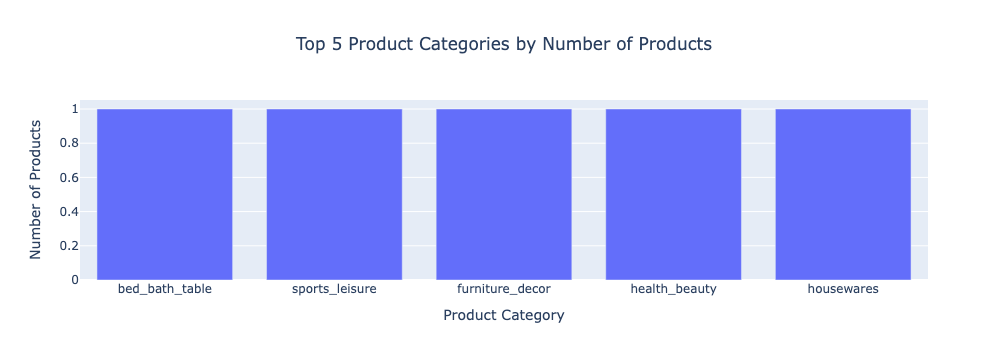

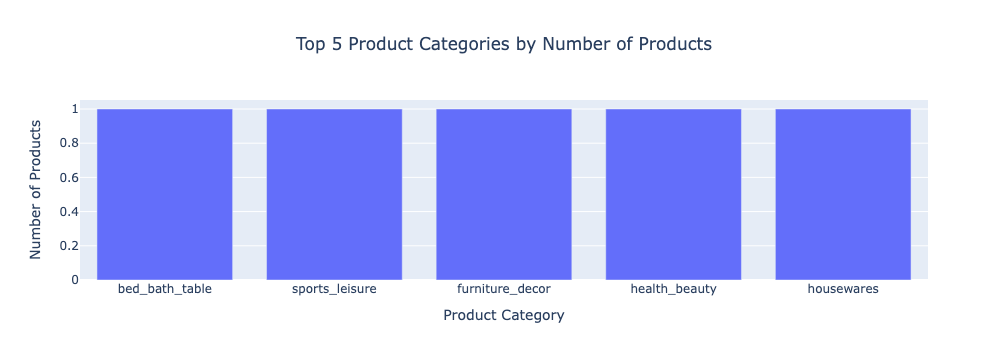


💡 ANSWER: Okay, here's a breakdown of what the database results tell us:

**In Simple Terms:**

The database query asked for the top 5 product categories that have the most products listed under them. The results show these are:

1.  **Bed, Bath & Table:** This category has the highest number of products.
2.  **Sports & Leisure:** This is the second largest category in terms of product count.
3.  **Furniture & Decor:** The third largest category.
4.  **Health & Beauty:** Followed by health and beauty products.
5.  **Housewares:** And finally, housewares.

**In essence, if you were to browse this e-commerce platform, you'd find the widest selection of items within the "Bed, Bath & Table" category, followed by "Sports & Leisure", and so on.**


In [25]:
# Test 2: Data Query (Should generate SQL and Analysis)
ask_database("What are the top 5 product categories by number of products?")

In [ ]:
# Test 3: Complex Query (Joins + Visualization)
ask_database("Show me the total payment value per payment type. Visualize as a pie chart.")


❓ USER: Show me the total payment value per payment type. Visualize as a pie chart.
--- 🛡️ Guardrails Checking: 'Show me the total payment value per payment type. Visualize as a pie chart.' ---
--- 🤖 Generating SQL ---


## 🎓 Takeaways

1.  **Abstraction**: By using `LiteLLM`, this agent can now run on Gemini, Claude, or OpenAI interchangeably.
2.  **Resilience**: The `error_agent` allows the system to recover from bad SQL without user intervention.
3.  **Structure**: `LangGraph` provides a clear, debuggable path for the conversation flow.

**Next Steps:** Try changing the `DEFAULT_MODEL` in your `.env` to `gemini/gemini-pro` and see how it performs!